# Tokyo Housing Database & Price Forecasting

In [ ]:
#Install the 'ipython-sql' and 'prettytable' libraries using pip
!pip install ipython-sql prettytable

# Import necessary Python modules for API calls, JSON handling, SQLite, datetime, and data analysis
import requests, json, sqlite3, sys, re
import pandas as pd
import numpy as np
import prettytable 
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
prettytable.DEFAULT = 'DEFAULT'

# Load SQL magic extension to run SQL queries directly in notebook cells
%load_ext sql

In [10]:
# Path to the SQLite database where scraped housing data will be stored
db = 'tokyo_housing.db'

# Base URL of Suumo (Japanese housing site)
base_url = 'https://suumo.jp/'

# URLs for initial listings pages 
starting_url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?url=%2Fchintai%2Fichiran%2FFR301FC001%2F&ar=030&bs=040&pc=50&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&cb=0.0&ct=25.0&md=01&md=02&md=03&md=04&md=05&md=06&md=07&md=08&md=09&md=10&et=20&mb=0&mt=9999999&cn=9999999&ra=013&ek=035017990&ek=035026830&rn=0350&ae=03501'

In [11]:
# Define TokyoHousingScraper to:
# - Scrape Tokyo housing listings from Suumo.jp
# - Collect listings, parse property details
# - Store the results in SQLite database

class TokyoHousingScraper:
    
    def __init__(self, db, base_url, url):
        # Initialize DB connection
        self.db = db
        self.conn = sqlite3.connect(self.db)
        self.cursor = self.conn.cursor()

        # Base URL and starting page
        self.base_url = base_url
        self.url = url
    
    def scrape_listings(self):
		# Define list for storing HTML
        self.listings = list()
		
		# Iterate through all pages of listings
        while True:
            try:
                response = requests.get(next_page) #this will only work after the first page
            except:
                response = requests.get(self.url) # starting url 
            soup = BeautifulSoup(response.text, 'lxml')
			
			# Each listing = cassetteitem div
            cassettes = soup.select('div.cassetteitem')
            self.listings.extend(cassettes)
            print(len(self.listings))

			# Find next page link (pagination)
            try:
                current_page = soup.find('li', class_ = 'pagination-current')
                next_page_path = current_page.find_next_siblings('li')[1]
                next_page = self.base_url + next_page_path.select_one('a').get('href')
            except: break #no more pages to comb through

        print(f'{len(self.listings)} listings were successfully gathered!')

    def parse_station_info(self, item):
		
        # Extract station information (names, distances, nearest, average).
        # Returns tuple: 
            # (stations_str, nearest_station, distance_to_nearest_station, avg_distance).

		# Get raw station blocks
        stations_list = item.select('li.cassetteitem_detail-col2 div.cassetteitem_detail-text'
		) if item.select(
			'li.cassetteitem_detail-col2 div.cassetteitem_detail-text'
		) else None

		# If there is no station information, return None
        if stations_list == None:
            return (None, None, None, None)
        else: pass

		# Remove empty tags
        stations_list = [s for s in stations_list if s != '']

		# All stations as a single string (for DB storage)
        self.stations_str = ",".join([station.get_text().strip() for station in stations_list])
	
		# Extract stations and distances with regex
        stations_dict = {
			# All listed stations
			'stations': [
				re.findall(r'/(?P<station>.*?)\s*歩', station.get_text().strip())[0] 
				for station in stations_list
				if re.findall(r'/(?P<station>.*?)\s*歩', station.get_text().strip())
			],
		
			'distances': [
				re.findall(r'\d+', station.get_text().strip())[0]
				for station in stations_list
				if re.findall(r'\d+', station.get_text().strip())
			]
		}
	
		# Compute distance to nearest station
        self.distance_to_nearest_station = min([int(dist) for dist in stations_dict['distances']])
        nearest_idx = stations_dict['distances'].index(str(self.distance_to_nearest_station))
        self.nearest_station = stations_dict['stations'][nearest_idx]
	
		# Compute average distance to surrounding stations
        self.avg_distance = np.mean([float(dist) for dist in stations_dict['distances']])

        return self.stations_str, self.nearest_station, self.distance_to_nearest_station, self.avg_distance

    def build_housing_dataset(self):
		
		# Extract housing data (title, rent, floor, area, stations, etc.)
            # and save into SQLite as a DataFrame.

        self.housing_data = [
		{
			'img': item.select_one(
                'div.cassetteitem_object img'
            ).get('rel') if item.select_one(
                'div.cassetteitem_object img'
            ) else None,
            
            'title': item.select_one(
				'div.cassetteitem_content-title'
			).get_text().strip() if item.select_one(
				'div.cassetteitem_content-title'
			) else None,
		
			'address': item.select_one(
				'li.cassetteitem_detail-col1'
			).get_text().strip() if item.select_one(
				'li.cassetteitem_detail-col1'
			) else None,
		
			'rent': item.select_one(
				'span.cassetteitem_price.cassetteitem_price--rent'
			).get_text().strip() if item.select_one(
				'div.cassetteitem-item span.cassetteitem_price.cassetteitem_price--rent'
			) else None,
		
			'management_fee': item.select_one(
				'span.cassetteitem_price.cassetteitem_price--administration'
			).get_text().strip() if item.select_one(
				'span.cassetteitem_price.cassetteitem_price--administration'
			) else None,
		
			'deposit': item.select_one(
				'span.cassetteitem_price.cassetteitem_price--deposit'
			).get_text().strip() if item.select_one(
				'span.cassetteitem_price.cassetteitem_price--deposit'
			) else None,

			'key_money': item.select_one(
				'span.cassetteitem_price.cassetteitem_price--gratuity'
			).get_text().strip() if item.select_one(
				'span.cassetteitem_price.cassetteitem_price--gratuity'
			) else None,

			'floor': item.select(
				'div.cassetteitem-item tr.js-cassette_link td'
			)[2].get_text().strip() if item.select(
				'div.cassetteitem-item tr.js-cassette_link td'
			)[2] else None,
		
			'floor_plan': item.select_one(
				'span.cassetteitem_madori'
			).get_text().strip() if item.select_one(
				'span.cassetteitem_madori'
			) else None,

			'area': item.select_one(
				'span.cassetteitem_menseki'
			).get_text().strip() if item.select_one(
				'span.cassetteitem_menseki'
			) else None,

			'building_age': item.select(
				'li.cassetteitem_detail-col3 div'
			)[0].get_text().strip() if item.select(
				'li.cassetteitem_detail-col3'
			) else None,

			'building_size': item.select(
				'li.cassetteitem_detail-col3 div'
			)[1].get_text().strip() if item.select(
				'li.cassetteitem_detail-col3'
			) else None,

			'stations': self.parse_station_info(item)[0],

			'nearest_station': self.parse_station_info(item)[1],

			'distance_to_nearest_station': self.parse_station_info(item)[2],

			'avg_distance_to_stations': self.parse_station_info(item)[3]
		}
			for item in self.listings
		]

		# Save to DataFrame + SQLite
        self.housing_data_df = pd.DataFrame(self.housing_data)
        self.housing_data_df.to_sql(name = 'HOUSING_DATA', con = self.conn, if_exists = 'replace', index = False)

		# Close the DB connection
        self.conn.close()

In [12]:
# Instantiate scraper
scraper = TokyoHousingScraper(db, base_url, starting_url)

# Scrape housing listings
scraper.scrape_listings()

# Parse listing details and save dataset to SQLite
scraper.build_housing_dataset()

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1211
1211 listings were successfully gathered!


In [18]:
# Connect to SQLite database for querying listings 
conn = sqlite3.connect(db)
cursor = conn.cursor()

# Initialize SQL Magic with database connection
%sql sqlite:///tokyo_housing.db

In [ ]:
%%sql 
-- Remove the view if it already exists
DROP VIEW IF EXISTS TOKYO_HOUSING;

-- Create a cleaned + feature-engineered housing view
CREATE VIEW TOKYO_HOUSING AS

WITH STANDARDIZED_LISTINGS AS (
    SELECT 
        -- Basic identifiers
        img, title, address, 
        
        -- Convert rent/deposit/key money into numeric
        CAST(RTRIM(rent, '万円') AS FLOAT) * 10000 AS rent,
        CAST(RTRIM(management_fee, '円') AS INTEGER) AS management_fee,
        CAST(RTRIM(deposit, '万円') AS FLOAT) * 10000 AS deposit,
        CAST(RTRIM(key_money, '万円') AS FLOAT) * 10000 AS key_money,
        
        -- Convert floor to integer
        CAST(RTRIM(floor, '階') AS INTEGER) AS floor,
        
        -- Normalize floor plan labels 
        CASE
            WHEN floor_plan = 'ワンルーム' THEN '1R'
            ELSE floor_plan
        END AS floor_plan,
        
        -- Convert area to numeric (square meters)
        CAST(RTRIM(area, 'm2') AS FLOAT) AS area,
        
        -- Extract building age in years
        CAST(LTRIM(RTRIM(building_age, '年'), '築') AS INTEGER) AS building_age,
        
        -- Standardize building size
        CASE
            WHEN building_size LIKE '地下%' THEN 
                CAST(SUBSTR(building_size, 3, 1) AS INTEGER) +
                CAST(SUBSTR(building_size, 6, 1) AS INTEGER)
            WHEN building_size LIKE '地上%' THEN
                CAST(SUBSTR(building_size, 3, 1) AS INTEGER)
            ELSE CAST(RTRIM(building_size, '階建') AS INTEGER)
        END AS building_size,
        
        -- Station-related features
        stations,
        nearest_station,
        distance_to_nearest_station,
        ROUND(avg_distance_to_stations, 2) AS avg_distance_to_stations
    FROM HOUSING_DATA
),

FEATURED_LISTINGS AS (
    SELECT 
        img, title, address, rent, 
        
        -- Replace 0/invalid values with NULLs
        NULLIF(management_fee, 0) AS management_fee,
        NULLIF(deposit, -0.0) AS deposit,
        NULLIF(key_money, 0.0) AS key_money,
        floor, floor_plan, area, building_age,
        building_size, nearest_station,
        distance_to_nearest_station, avg_distance_to_stations,
        
        -- Feature engineering: average rents by station, floor plan, and distance to nearest station
        ROUND(AVG(rent) 
            OVER (PARTITION BY nearest_station), 2) 
            AS avg_rent_by_station, 
        ROUND(AVG(rent)
            OVER (PARTITION BY floor_plan), 2) 
            AS avg_rent_by_floor_plan,
        
        -- Price rank relative to other listings near the same station
        DENSE_RANK() 
            OVER (PARTITION BY nearest_station ORDER BY rent DESC)
            AS price_rank_by_station
    FROM STANDARDIZED_LISTINGS
)

-- Final output 
SELECT * FROM FEATURED_LISTINGS

In [ ]:
# Query the engineered SQL view into a pandas DataFrame for analysis
tokyo_housing = %sql SELECT * FROM TOKYO_HOUSING 
tokyo_housing_df = tokyo_housing.DataFrame()

# Close the DB connection 
conn.close()

In [16]:
# Drop duplicate listings 
tokyo_housing_df.drop_duplicates(inplace = True)

In [3]:
tokyo_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          1202 non-null   object 
 1   title                        1207 non-null   object 
 2   address                      1207 non-null   object 
 3   rent                         1207 non-null   float64
 4   management_fee               1034 non-null   float64
 5   deposit                      825 non-null    float64
 6   key_money                    788 non-null    float64
 7   floor                        1207 non-null   int64  
 8   floor_plan                   1207 non-null   object 
 9   area                         1207 non-null   float64
 10  building_age                 1207 non-null   int64  
 11  building_size                1207 non-null   int64  
 12  nearest_station              1207 non-null   object 
 13  distance_to_neares

In [4]:
tokyo_housing_df.describe(include = 'all')

,img,title,address,rent,management_fee,deposit,key_money,floor,floor_plan,area,building_age,building_size,nearest_station,distance_to_nearest_station,avg_distance_to_stations,avg_rent_by_station,avg_rent_by_floor_plan,price_rank_by_station
count,1202,1207,1207,1207.000000,1034.000000,825.000000,788.000000,1207.000000,1207,1207.000000,1207.000000,1207.000000,1207,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
unique,1202,1156,45,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN
top,https://img01.suumo.com/front/gazo/fr/bukken/4...,ＪＲ山手線 高田馬場駅 4階建 築3年,東京都新宿区高田馬場３,NaN,NaN,NaN,NaN,NaN,1K,NaN,NaN,NaN,中井駅,NaN,NaN,NaN,NaN,NaN
freq,1,4,100,NaN,NaN,NaN,NaN,NaN,517,NaN,NaN,NaN,235,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,101696.520298,6964.119923,106328.121212,115307.233503,2.717481,NaN,26.720017,22.607291,4.649544,NaN,5.353770,9.407026,101620.114391,101677.018028,43.293289
std,NaN,NaN,NaN,42696.128135,4196.799459,59970.635488,64419.889365,2.200682,NaN,13.045711,15.697647,3.054339,NaN,2.520552,2.298308,7978.506092,34782.337937,24.968109
min,NaN,NaN,NaN,30000.000000,200.000000,30000.000000,30000.000000,0.000000,NaN,0.000000,0.000000,1.000000,NaN,1.000000,2.000000,85730.770000,63000.000000,1.000000
25%,NaN,NaN,NaN,69000.000000,3000.000000,69000.000000,74000.000000,1.000000,NaN,19.030000,9.000000,2.000000,NaN,3.000000,7.670000,97854.650000,74262.690000,22.000000
50%,NaN,NaN,NaN,89000.000000,6000.000000,87000.000000,94000.000000,2.000000,NaN,24.610000,21.000000,4.000000,NaN,5.000000,9.670000,104994.060000,87425.190000,43.000000
75%,NaN,NaN,NaN,125000.000000,10000.000000,125000.000000,138000.000000,3.000000,NaN,31.050000,35.000000,6.000000,NaN,7.000000,11.000000,106420.470000,108070.420000,63.000000


In [ ]:
# Compute correlation matrix for all numeric features
housing_corr = tokyo_housing_df.select_dtypes(['int64', 'float64']).corr()

# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Plot heatmap of correlations
sns.heatmap(data = housing_corr, cmap = 'vlag', annot = True, linecolor = 'black', linewidths = 0.5, fmt = '.2f', cbar_kws = {'label': 'Correlation Coefficient'})

# Set figure title
fig.suptitle('Correlation Heatmap of Housing Metrics', fontweight = 'bold', fontsize = 18)

plt.tight_layout()
plt.savefig('correlation.png')

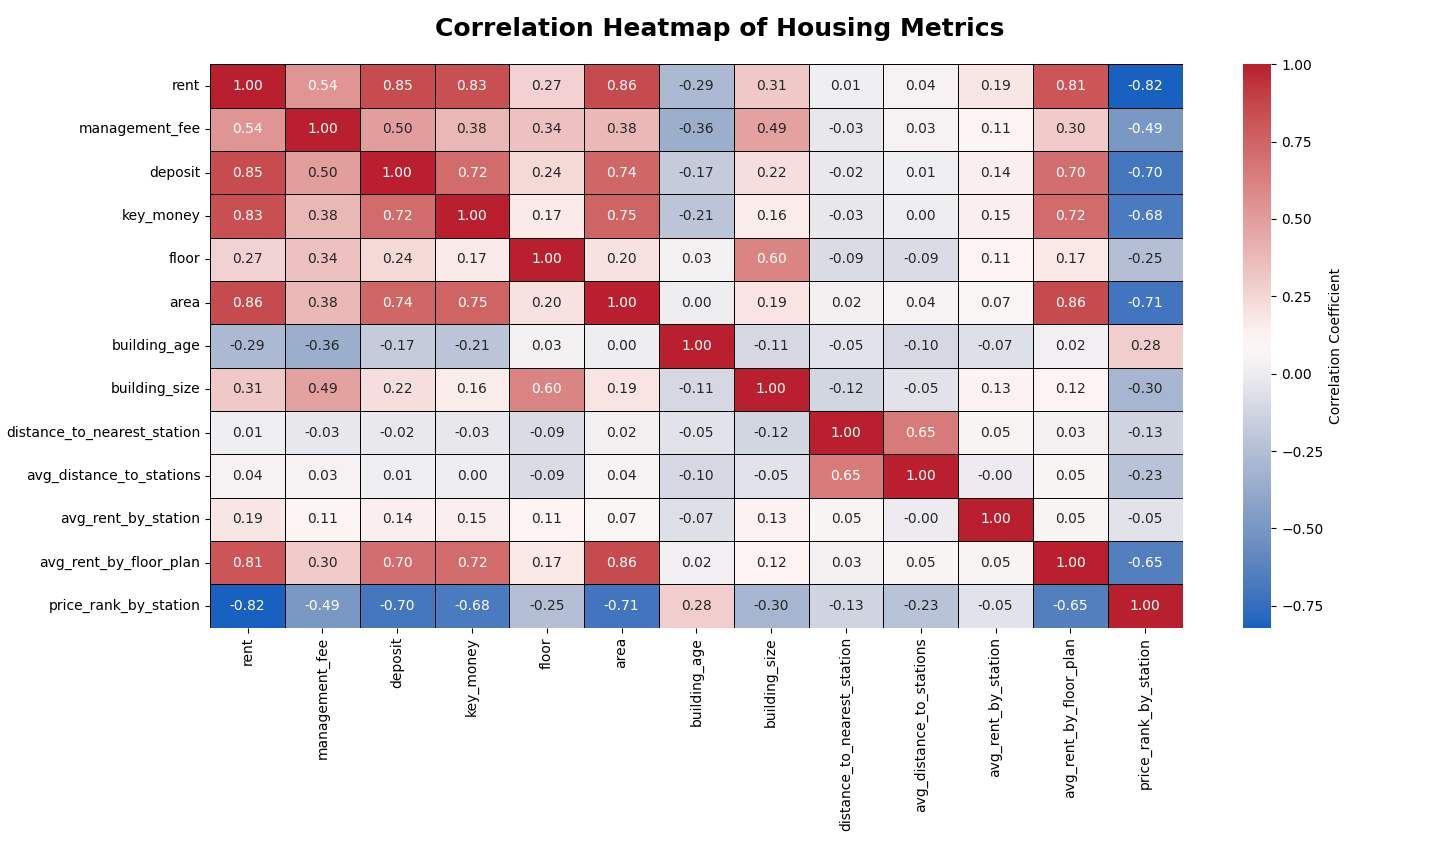

In [21]:
# Convert floor_plan values to dummy variables for regression
dummies = pd.get_dummies(tokyo_housing_df['floor_plan'], dtype = 'int', drop_first = True)

# Get dummy columns 
dummy_cols = dummies.columns.to_list()

# Concatenate dummy columns to DataFrame
tokyo_housing_df = pd.concat([tokyo_housing_df, dummies], axis = 1)

# Define X, y for LinearRegression
X = tokyo_housing_df[['area'] + dummy_cols]
y = tokyo_housing_df['rent']

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize model 
lr0 = LinearRegression()

# Simple Linear Regression
X_train_0 = X_train[['area']]

# Compute scores for 5-fold cross validation on training dataset
score_0 = cross_val_score(lr0, X_train_0, y_train, cv = 5).mean()
print(f'The average of the R-squared values is {score_0: .3f}')

The average of the R-squared values is  0.718


In [22]:
# Initialize model                            
lr1 = LinearRegression()

# Initialize scaler object & standardize data for regression
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Multiple Linear Regression
score_1 = cross_val_score(lr1, X_train_scaled, y_train, cv = 5).mean()
print(f'The average of the R-squared values is {score_1: .3f}')

The average of the R-squared values is  0.740


In [25]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.predict(X_train_scaled)

# Make predictions on training and testing sets
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Evaluate on training set
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared value the training set: {r2_train: .3f}')

# Evaluate on testing set
r2_test = r2_score(y_test, y_test_pred)
print(f'R-squared value on the testing set: {r2_test: .3f}')

R-squared value the training set:  0.754
R-squared value on the testing set:  0.800


In [ ]:
# Compute the residuals 
y_resid = y_test_pred - y_test

# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Scatter plot for residuals
plt.scatter(X_train, y_resid)

In [17]:
# Save DataFrame to CSV file
tokyo_housing_df.to_csv('tokyo_housing.csv', index = False)